# Homework 6
## Yuxin Sun
-------

### 1. Datasets
According to the HW6 instruction, I use a filtered 2014Train/Val COCO dataset.
Examples of the data feed into network are shown below, each original bounding box is larger than 4096 pixels.

Figure 1: Train Dataset

![schematic train data](show_train.png)

Code:

```python
class MyDataset(torch.utils.data.Dataset):

    ...

    def __getitem__(self, index):
        im   = self.coco.loadImgs(self.imgIds[index])[0]
        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=self.imgIds[index]))
        path = '%s/%s'%(self.dir, im['file_name'])
        pil_image = Image.open(path)
        img_tensor = self.xform(pil_image)
        labs_tensor = torch.LongTensor([13]*5)      # number 13 will not be used
        cell_ids = torch.zeros(5, dtype=torch.uint8)
        anchor_ids = torch.zeros(5, dtype=torch.uint8)
        # add one class for 'other object'
        yolo_vectors = torch.zeros(5, 5 + len(self.catIds) + 1, dtype=torch.float)
        i = 0
        for ann in anns:
            if ann['category_id'] in self.catIds \
            and ann['area'] >= self.data.minArea:
                bbox_renormalized = xywh_to_ccwh(self.resize(im, ann['bbox']))
                label = self.catId_to_label[ann['category_id']]
                cell_ids[i], dx, dy = calc_cell_id(bbox_renormalized, self.yolo_interval)
                anchor_ids[i], sw, sh = calc_anchor_id(bbox_renormalized, self.yolo_interval)
                labs_tensor[i] = label
                yolo_vectors[i, 0] = 1
                yolo_vectors[i, 1:5] = torch.tensor([dx, dy, sw, sh],dtype=float)
                yolo_vectors[i, 5+label] = 1

                i += 1
                if i >= 5:
                    break
        return img_tensor, labs_tensor, yolo_vectors, cell_ids, anchor_ids

```
The `__getitem__` method is used to get the data from the dataset. In my implementation, this function will `return img_tensor, labs_tensor, yolo_vectors, cell_ids, anchor_ids`:
 - `img_tensor`: a tensor of shape (C, H, W)
 - `labs_tensor`: a tensor of shape (Nc)
 - `yolo_vectors`: a tensor of shape (Nc, 9)
 - `cell_ids` and `anchor_ids`: a tensor of shape (Nc)

where `Nc=5` in my code.

`yolo_vector[0]` is the objectness.

`yolo_vector[1:5]` represents the bounding box of the object. Last two parameter are generated by $\ln (\frac{w_\text{gt}}{w_\text{archor}})$ and $\ln (\frac{h_\text{gt}}{h_\text{archor}})$.

`yolo_vector[5:9]` represents the one hot class.

### 2. Network Architecture

The network architecture is based on the original ResNet code.

The basic SkpiBlock architecture is as follows:
```python
class SkipBlock(nn.Module):
    def __init__(self, in_ch, out_ch, ker=3, *, stride=1, padding=1) -> None:
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.stride = stride
        self.conv1 = nn.Conv2d(in_ch, out_ch, ker, stride=stride, padding=padding, bias=False)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        if stride != 1 or in_ch != out_ch:
            # would have bugs if ker!=3
            if stride != 2:
                raise ValueError('Currently stride must be 1 or 2.')
            self.downsampler = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(out_ch),
            )
        else:
            self.downsampler = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampler is not None:
            identity = self.downsampler(x)
        out = out + identity
        out = self.relu(out)

        return out
```

HW6Net:
```python
class HW6_YOLO(nn.Module):

    def __init__(self, train_data, test_data, ngf=32, size=256) -> None:
        super().__init__()
        self.train_dataset = train_data
        self.val_dataset = test_data

        # The first convolution layer. Input shape: (B, 3, 256, 256)
        model = nn.ModuleList([
            nn.Conv2d(3, ngf, 7, padding=3),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
        ])
        # out_size: 256
        new_size = calc(size, 7, padding=3)

        # The second convolution layer, downsample only once before skip-block
        model.extend([
            nn.Conv2d(ngf, ngf * 2, 5, stride=3, padding=2),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
        ])
        # out_size: 86
        new_size = calc(new_size, 5, stride=3, padding=2)

        # The skip-blocks
        new_in_ch = ngf * 2
        num_blocks = [6, 6, 4]
        new_out_chs = [64, 128, 256]
        for i in range(len(num_blocks)):
            new_out_ch = new_out_chs[i]
            num_block  = num_blocks[i]
            model.extend(
                self._gen_skip_blocks(new_in_ch, new_out_ch, num_block, stride=2, padding=1)
            )
            new_in_ch = new_out_ch
            new_size = calc(new_size, 3, stride=2, padding=1)
        # out_size: 11

        model.append(nn.MaxPool2d(3, stride=2, padding=0))
        new_size = calc(new_size, 3, stride=2, padding=0)
        # out_size: 256x5x5

        self.model = nn.Sequential(*model)

        self.fc = nn.Sequential(
            nn.Linear(new_out_ch*int(new_size*new_size), 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2048),
            nn.Sigmoid(),
            # 8 * 8 * 5 * 9 = 2880
            nn.Linear(2048, yolo_interval**2 * 5 * 9),
        )

    def forward(self, x):
        out = self.model(x)
        out = out.view(-1, 256*5*5)
        out = self.fc(out)
        return out
    
    @staticmethod
    def _gen_skip_blocks(in_ch, out_ch, num_layer, *, stride=1, padding=1):
        # the first skip-block will downsample the input if necessary.
        layers = [SkipBlock(in_ch, out_ch, stride=stride, padding=padding),]
        for _ in range(1, num_layer):
            # the following skip-blocks will keep the input size unchanged.
            layers.append(SkipBlock(out_ch, out_ch, stride=1, padding=1))
        return layers
```

As stated in the comment above, the output shape (C, H, W) of the last skip-block is (256, 5, 5).
The output size of the last fully-connected layer is $8\times 8\times 5\times 9 = 2880$.

The length of `yolo_vector` is 9 rather than 8, because we use four classes: bus, cat, pizza and others. But we will only feed data that belong to first 3 classes.

The Architecture of my network generated by torchviz:

Figure 2

![net](net.svg)


### 3. Training


I use torch.nonzero() to avoid the explicit `for` loop. In this way we can calculate the loss by using yolo_vectors with non-zero objectness.
```python
    filter = yolo_vectors[:,:,0].nonzero(as_tuple=True)
    yolo_vectors = yolo_vectors[filter]
```

The `filter` is also used to filter out other tensors.

By running
```python
loss_record = train_yolo(net, device=dml, epoch_size=3, step_size=10e-5)
```
We see

Figure 3:

![Figure 3](3_loss.png)
 

### 4. Testing

According to Week 8's slides, for each cell I keep one best anchor box, 
and then select 5 yolo vectors with highest objectness(`yolo_vector[0]`).

Before comparing those 5 predicted results with GT bounding boxes, I remove vectors that `torch.all(class_labels_prob < 0.3)`, and then apply the Non-maximum Suppression. Now there are usually 1 or 2 vectors survived. I compare them with GT bounding boxes.

Result:

class list:  	bus  cat  pizza
total predict:	 34   49   35
total correct:	 34   37   32
average IoU:	0.27  0.26  0.37
prediction precision: 0.872881


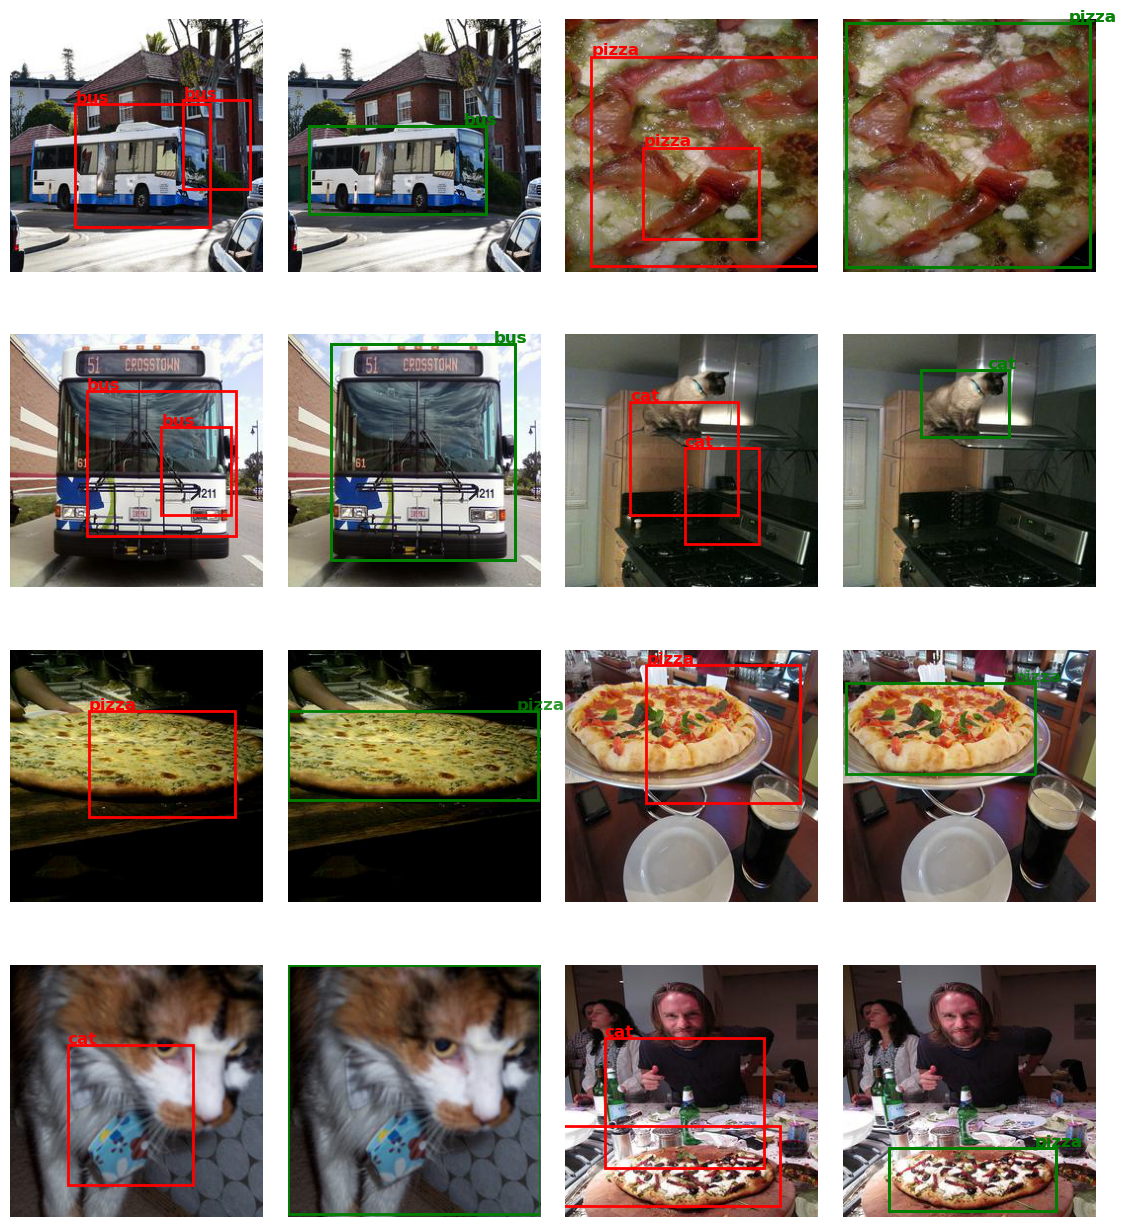

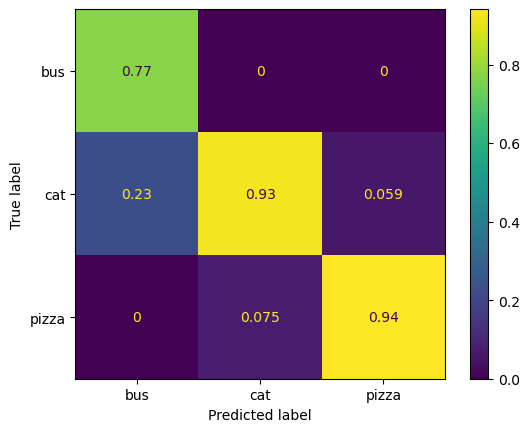

tensor([[34.,  0.,  0.],
        [10., 37.,  2.],
        [ 0.,  3., 32.]])

<Figure size 640x480 with 0 Axes>

In [ ]:
gc.collect()
test_yolo(net, plot_image=True)

#Figure 4 below

Red boxes(left) are predicted bounding boxes, and green ones(right) are ground truth bounding boxes which have the same label and maximium IoU with the predicted bounding box.

The confusion matrix is normalized by dividing the predicted numbers of each class, 

Here's another result:

class list:  	bus  cat  pizza
total predict:	 37   36   49
total correct:	 34   31   42
average IoU:	0.27  0.26  0.31
prediction precision: 0.877049


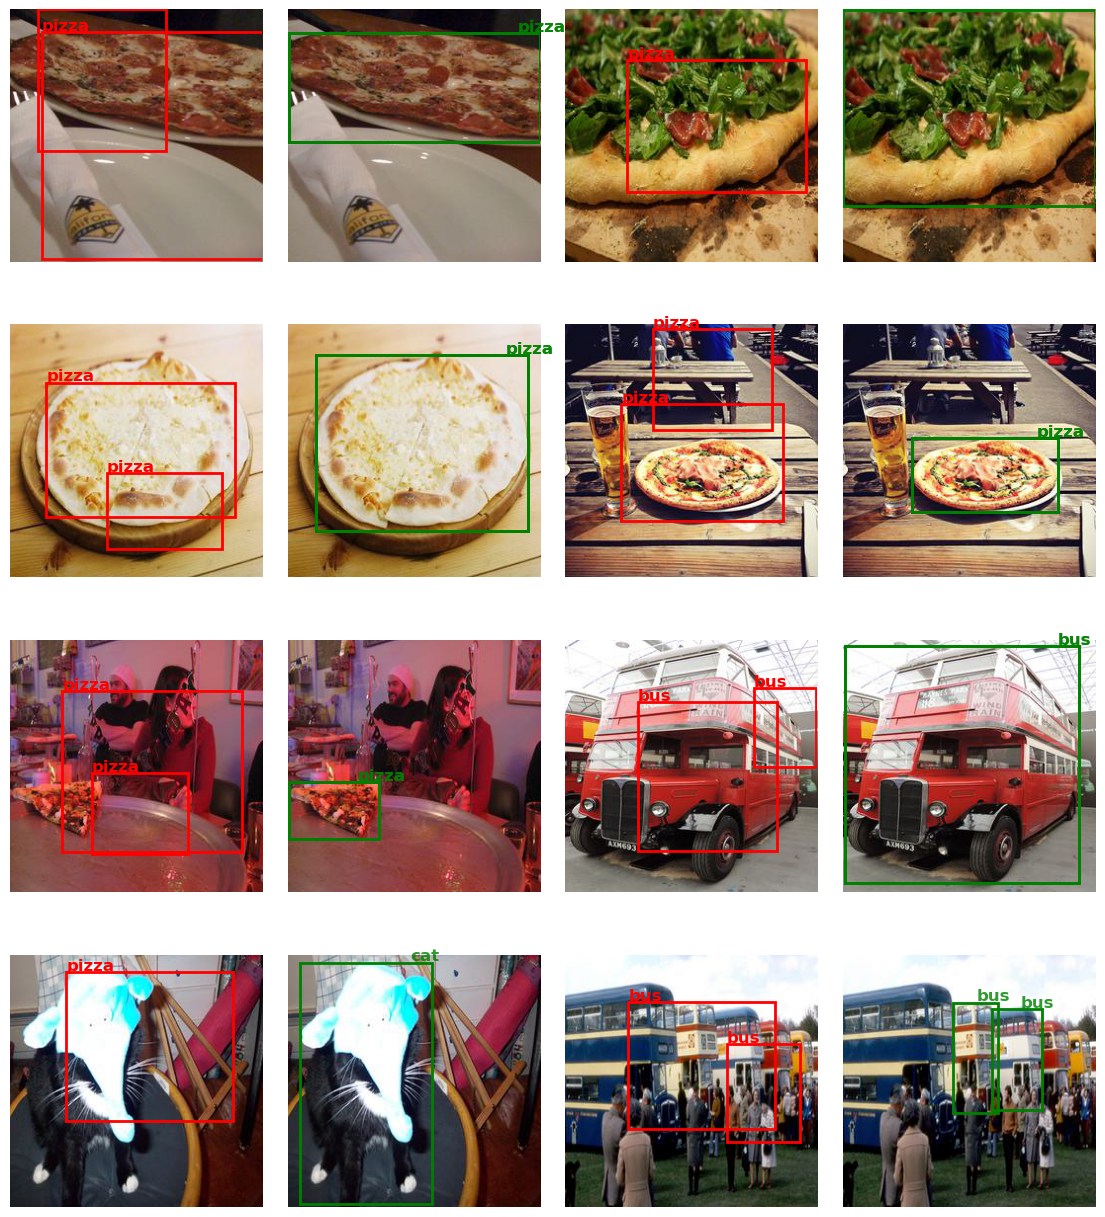

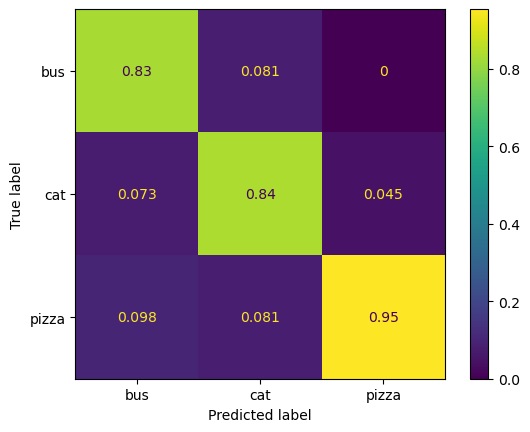

tensor([[34.,  3.,  0.],
        [ 3., 31.,  2.],
        [ 4.,  3., 42.]])

<Figure size 640x480 with 0 Axes>

In [ ]:
gc.collect()
test_yolo(net, plot_image=True)

#Figure 5 below

### 5. Discussion

In my case, the network will predict additional bounding boxes, even after doing a simple non-maximum suppression. The average precision is approximately $0.8$. 

The performance of my network is not good for this task. There might be some improvements by using different optimizers, or using other format of bounding box parameters rather than $\big[\Delta x$, $\Delta y$, $\ln(w_\text{gt}/w_\text{anchor})$, $\ln(h_\text{gt}/h_\text{anchor})\big]$.

The first 6 images below show good results for my net, and the last 2 images show the extra-box problem and the misclassification problem.

good - 1

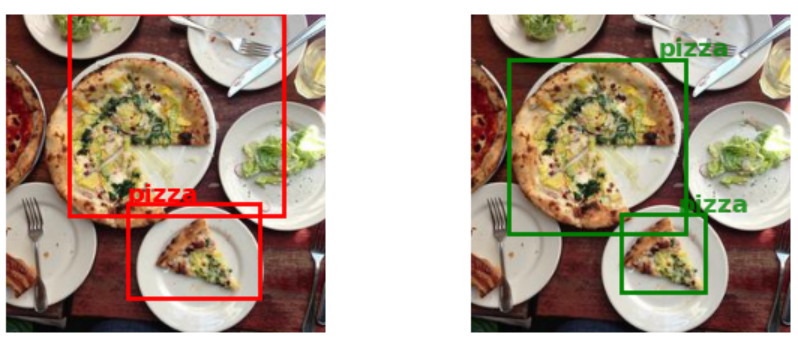

good - 2

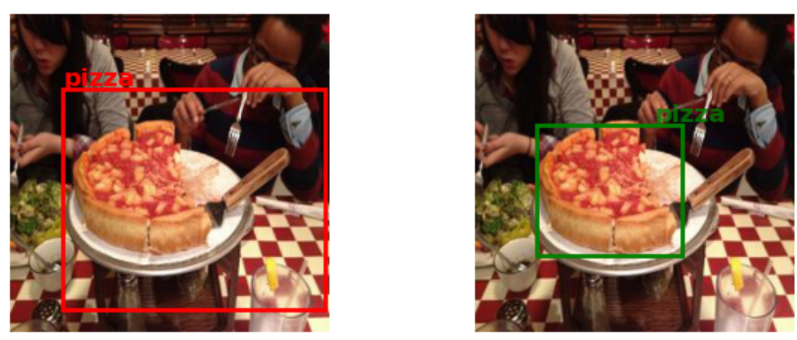

good - 3

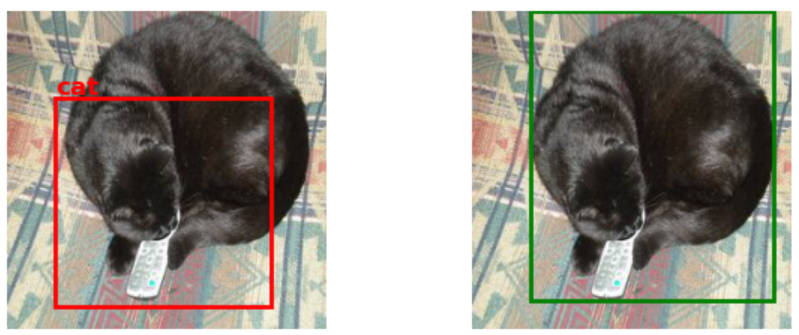

good - 4

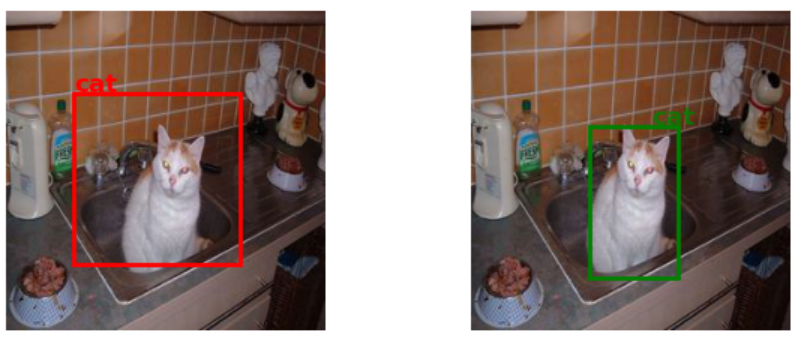

good - 5

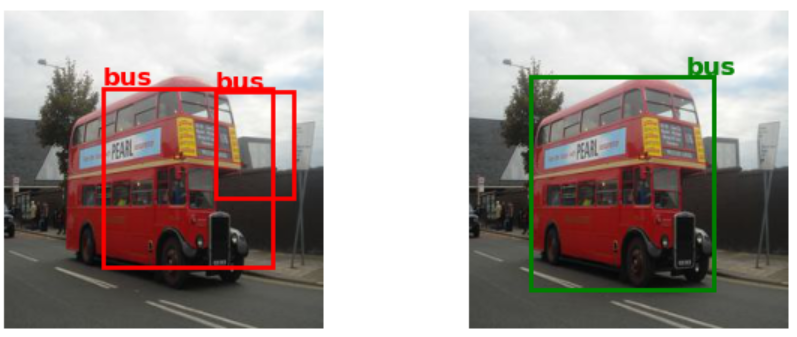

good - 6

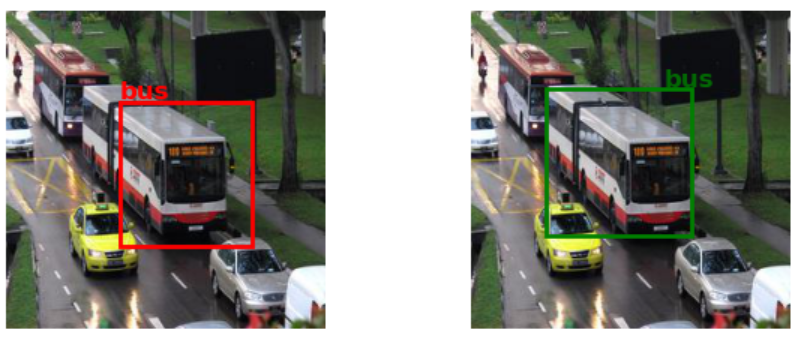

bad - 1

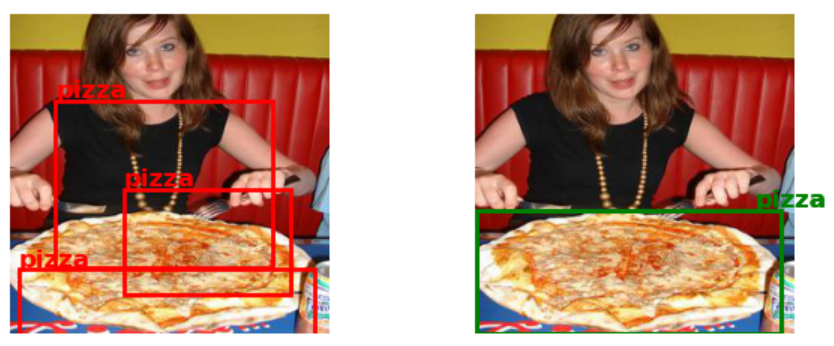

bad - 2

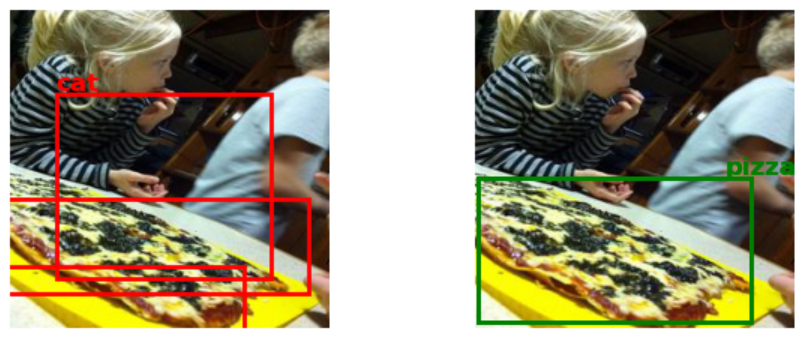

### Some extra things I learned

I met some confusing bugs that are hard to fix. 

For example, the following bug (red font) is caused by wrong type of tensor sent to `CrossEntropyLoss` on GPU: the function need torch.LongTensor(...), but I use `uint8`.
This bug will not appear if I test my code on CPU. (The normal font shows another problem that DirectML doesn't support `ReflectionPad2D` on AMD GPU.)

In [ ]:
net = HW6_YOLO(train_set, val_set, ngf=32, size=256)
train_yolo(net, device=dml)

/home/parry/.conda/envs/amd-torch/lib/python3.8/site-packages/torch/nn/modules/padding.py:178: UserWarning: The operator 'aten::reflection_pad2d' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /home/vsts/work/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return F.pad(input, self.padding, 'reflect')


: 

: 

So I think it is also necessary to always test code on GPU, especillarly when I am using an AMD GPU.